In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import sys
import os


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np
import pandas as pd
import seaborn as sns

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.env_setup import EnvironmentFactory
from dqn.opinion_dynamics.utils.experiment import instantiate_agent
from dynamic_programming.opinion_dynamics.common.viz import (
    interpolate_opinion_trajectory,
    plot_action_heatmap,
    plot_opinions_over_time,
)
from dqn.opinion_dynamics.experiments.baseline import flatten_intermediate_states_np, run_policy_agent


2025-10-20 12:04:13,454 - dqn - INFO - opinion_dqn.py:139 - asserts_enabled=True, optimize=0, PYTHONOPTIMIZE=None
2025-10-20 12:04:13,464 - dqn - INFO - <string>:26 - Loaded configuration settings.
2025-10-20 12:04:13,472 - dqn - INFO - opinion_dqn.py:499 - Initialized networks and optimizer.
2025-10-20 12:04:24,887 - dqn - INFO - opinion_dqn.py:250 - Loaded previous training status from the following files: {'replay_buffer_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Oct20-022113_configs\\0000_estimator.model_OpinionNet__optim.args_.lr_5e-05__agent_params.args_.target_soft_tau_0.003__experiment_fixed_res\\1\\fixed_res_replay_buffer', 'train_stats_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Oct20-022113_configs\\0000_estimator.model_OpinionNet__optim.args_.lr_5e-05__agent_params.args_.target_soft_tau_0.003__experiment_fixed_res\\1\\fixed_res_train_stats', 'checkpoint_model_file': 'd:\\Work\\r

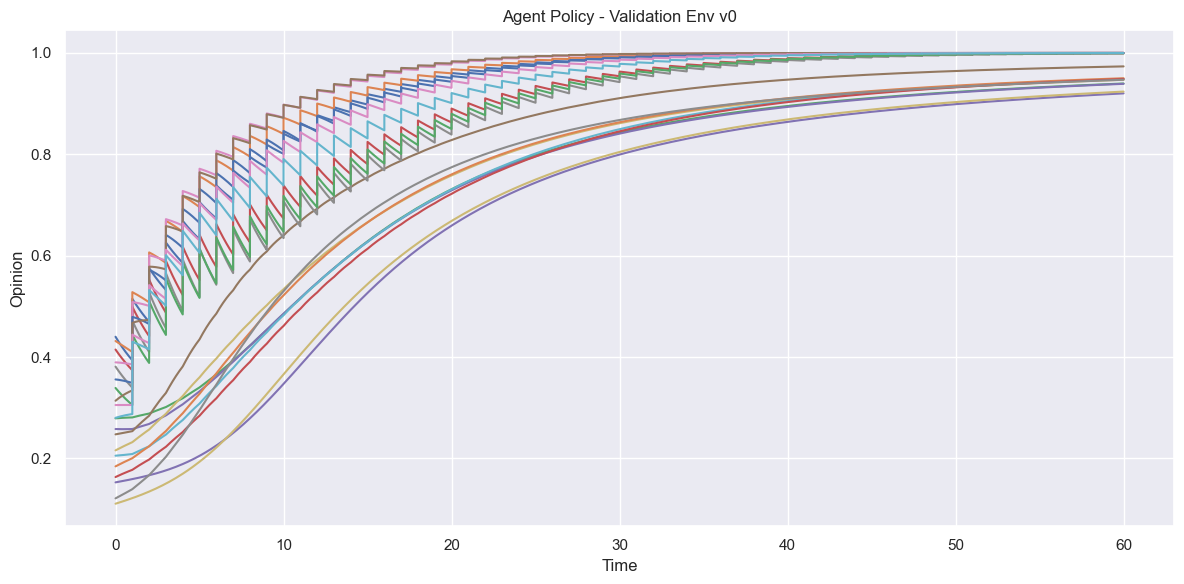

Total discounted reward: -12.0827

--- Running agent on validation environment version 1 ---
Simulation ended at step 59: done=False, truncated=True


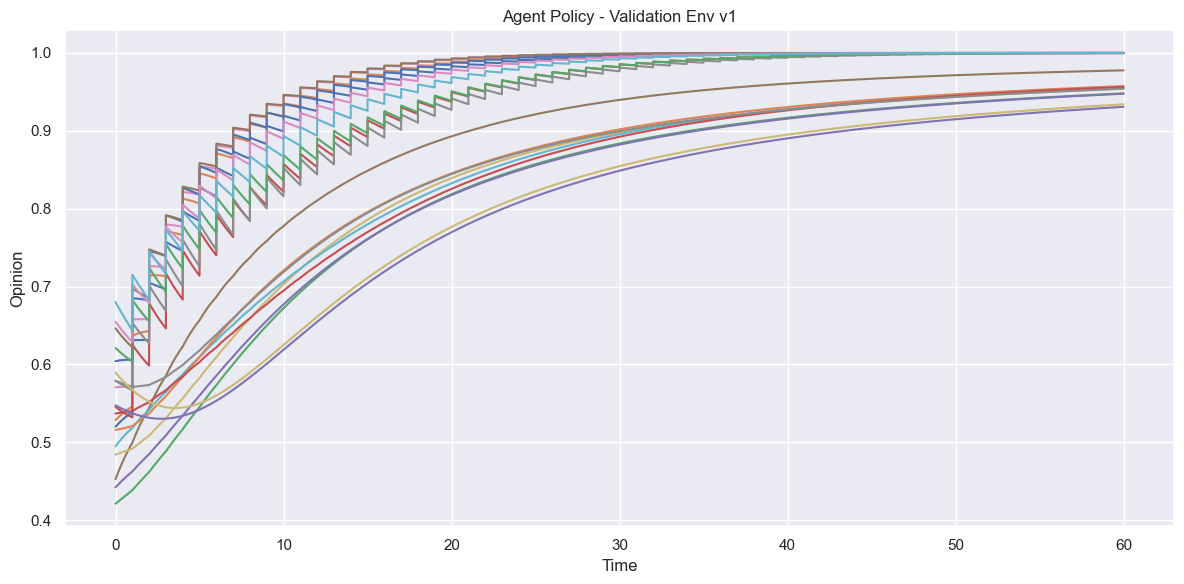

Total discounted reward: -8.2889

--- Running agent on validation environment version 2 ---
Simulation ended at step 59: done=False, truncated=True


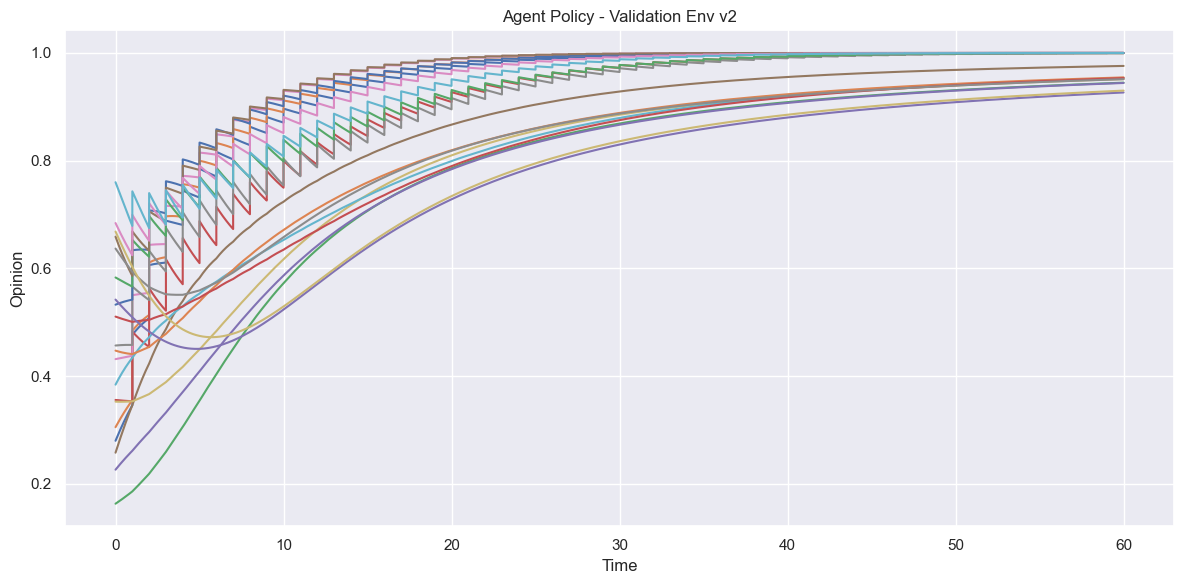

Total discounted reward: -9.5945
   version  discounted_reward
0        0         -12.082682
1        1          -8.288874
2        2          -9.594501


In [27]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1" # excellent run

# was a decent run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May29-012929_configs\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\1"

# exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul09-171538_configs\0000_agent_params.args_.target_model_update_freq_5000__agent_params.args_.training_freq_4\2"

# exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul15-014518_configs\0000_agent_params.args_.target_model_update_freq_2500\2"

# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul25-031713_configs\0001_agent_params.args_.betas__0__1__2_\1"

# Great behavior with multiple budget levels!
# exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Sep08-142952_configs\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experiment_opinion_agent_dqn_fixed_steps\1"

exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Oct20-022113_configs\0000_estimator.model_OpinionNet__optim.args_.lr_5e-05__agent_params.args_.target_soft_tau_0.003__experiment_fixed_res\1"


agent = instantiate_agent(exp_subdir)

results = []
df_actions_list = []

env_versions = agent.env_factory.validation_versions
# env_versions = [0]

for version in range(len(env_versions)):
    print(f"\n--- Running agent on validation environment version {version} ---")

    # Force environment to version
    agent.validation_env = agent.env_factory.get_validation_env(version=version)

    # Run policy with agent
    states, times, rewards, actions, all_intermediate_states = run_policy_agent(agent)

    actions_np = np.asarray(actions)                 # shape (T, N)
    T, N = actions_np.shape[0], actions_np.shape[1]

    df_actions_v = pd.DataFrame(
        actions_np,
        columns=[f"a_{j}" for j in range(N)]
    )
    df_actions_v.insert(0, "t_idx", np.arange(T))
    df_actions_v.insert(0, "version", version)

    df_actions_list.append(df_actions_v)

    flat_states, flat_times = flatten_intermediate_states_np(
        all_intermediate_states,
        agent.validation_env.t_campaign,
        agent.validation_env.t_s
    )
    plot_opinions_over_time(flat_states, flat_times, title=f"Agent Policy - Validation Env v{version}")

    total_value = sum((agent.gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    results.append({"version": version, "discounted_reward": total_value})

# Per-version results (unchanged)
df_results = pd.DataFrame(results)
print(df_results)



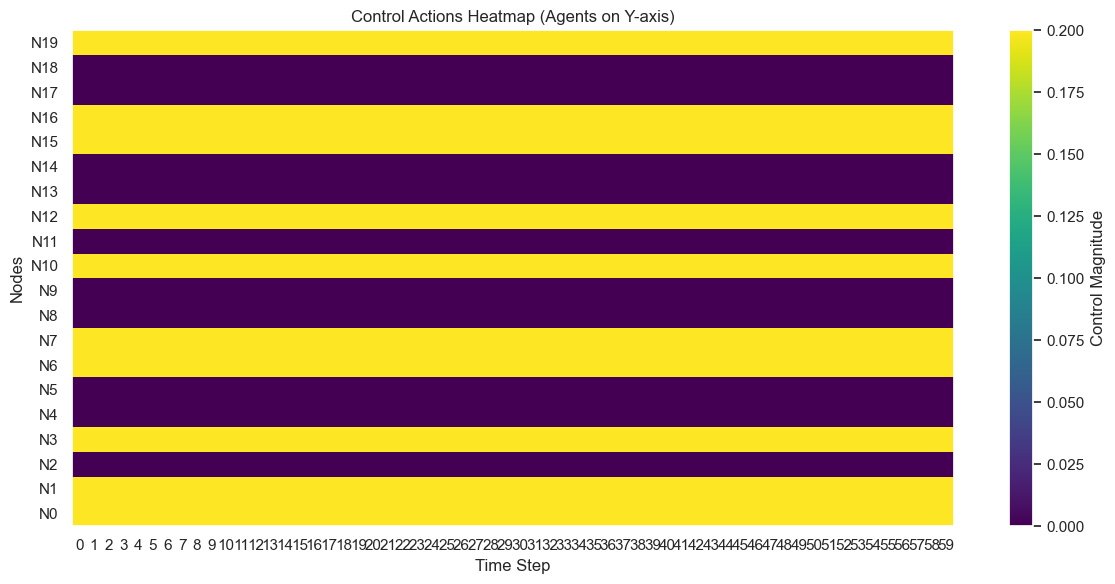

In [28]:
plot_action_heatmap(actions)

In [29]:
def summarize_action_mass_by_step(df_actions: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a tidy DataFrame with, for each version and step, the sum of the action vector.
    Columns: version, t_idx, action_sum
    """
    action_cols = [c for c in df_actions.columns if c.startswith("a_")]
    out = df_actions.copy()
    out["action_sum"] = out[action_cols].sum(axis=1)
    out = out[["version", "t_idx", "action_sum"]].sort_values(["version", "t_idx"]).reset_index(drop=True)
    return out

def action_mass_wide(df_actions: pd.DataFrame) -> pd.DataFrame:
    df = summarize_action_mass_by_step(df_actions)
    return df.pivot(index="t_idx", columns="version", values="action_sum").sort_index()

df_actions = pd.concat(df_actions_list, ignore_index=True)
df_mass = summarize_action_mass_by_step(df_actions)
df_actions

df_mass_w = action_mass_wide(df_actions)  # nice for plotting
df_mass_w.head()

version,0,1,2
t_idx,,,
0,2.0,2.0,2.0
1,2.0,2.0,2.0
2,2.0,2.0,2.0
3,2.0,2.0,2.0
4,2.0,2.0,2.0


In [30]:
version = 0
vals = df_mass_w[version].tolist()
vals

[2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,
 2.000000238418579,


In [31]:
gamma = 0.99
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r

total_value

-9.59450099949289

-11.374737996424848


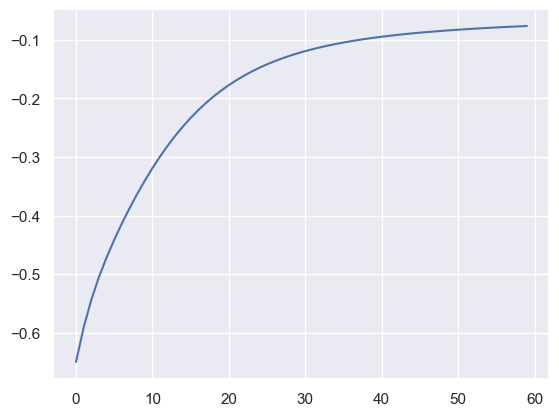

In [32]:
# plot rewards with seaborn

sns.lineplot(x=np.arange(len(rewards)), y=rewards)
print(sum(rewards))

In [33]:
# Add multiple budget levels
# Retrieve the budget levels used and plug into NAHS control

In [34]:
np.sum(actions, axis=1)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32)

In [35]:
sum(rewards)

-11.374737996424848

In [36]:
# array of 20 rand elements between 0 and 1
state = np.random.rand(20)
state_tensor = torch.tensor(state, dtype=torch.float32)
(u, beta_idx, w_full, max_q) = agent.select_action(state_tensor, epsilon=1, random_action=True)

print(beta_idx)
print(u.sum())

[0]
0.099999994
